In [199]:
import pandas as pd
import numpy as np
import pygmo as pg
import random
import functools
import math as m
import copy
from numpy import genfromtxt

# Geometry modules
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches 
import seaborn as sns

# Misc
import time 
from time import process_time
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
import secrets

# skopt
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV, space, plots
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize

# sklearn modules
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, recall_score
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from skfeature.function.similarity_based import fisher_score

# For ignoring warnings about bad classifiers - it's the nature of the algorithm to come across these
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.impute import SimpleImputer
import sklearn_relief as relief


# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [200]:
df = pd.read_csv(r'churn_new.csv')
df = df.drop(['Customer ID'], axis=1)
df.shape

(7043, 45)

### Replace spaces with underscores

In [201]:
def replace_spaces_with_underscores(dataframe):
    new_columns = [column.replace(" ", "_") for column in dataframe.columns]
    dataframe.columns = new_columns
    return dataframe

In [202]:
df = replace_spaces_with_underscores(df)

### Imbalance

In [203]:
df['Churn_Value'].value_counts()

0    5174
1    1869
Name: Churn_Value, dtype: int64

In [204]:
imb = df['Churn_Value'].value_counts()[1]/df.shape[0]
print(f"Imbalance: the class of interest is {np.round(imb,2)*100}% of the dataset")

Imbalance: the class of interest is 27.0% of the dataset


### Finding NaNs

In [205]:
def print_columns_with_nas(dataframe):
    columns_with_nas = dataframe.columns[dataframe.isna().any()].tolist()

    if not columns_with_nas:
        print("No columns with NAs found.")
        return

    for column in columns_with_nas:
        na_count = dataframe[column].isna().sum()
        print(f"Column '{column}' has {na_count} NaN(s).")


In [206]:
print_columns_with_nas(df)

Column 'Churn_Category' has 5174 NaN(s).
Column 'Churn_Reason' has 5174 NaN(s).
Column 'Customer_Satisfaction' has 5209 NaN(s).


### Cutting features matrix

In [207]:
X = df.drop(['Churn_Value'],axis=1).copy()
y = df.Churn_Value.copy()

In [208]:
object_cols = X.select_dtypes(include='object').columns

print(object_cols)

Index(['Referred_a_Friend', 'Offer', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
       'Device_Protection_Plan', 'Premium_Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract',
       'Paperless_Billing', 'Payment_Method', 'Gender', 'Under_30',
       'Senior_Citizen', 'Married', 'Dependents', 'City', 'Churn_Category',
       'Churn_Reason'],
      dtype='object')


In [209]:
number_cols = X.select_dtypes(include=['int','float']).columns
print(number_cols)

Index(['Number_of_Referrals', 'Tenure_in_Months',
       'Avg_Monthly_Long_Distance_Charges', 'Avg_Monthly_GB_Download',
       'Monthly_Charge', 'Total_Regular_Charges', 'Total_Refunds',
       'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Age',
       'Number_of_Dependents', 'Zip_Code', 'Latitude', 'Longitude',
       'Population', 'CLTV', 'Total_Customer_Svc_Requests',
       'Product/Service_Issues_Reported', 'Customer_Satisfaction'],
      dtype='object')


In [210]:
def get_unique_values_count(dataframe):
    unique_values_counts = dataframe.nunique().reset_index()
    unique_values_counts.columns = ['Column', 'Unique_Values_Count']
    return unique_values_counts

In [211]:
object_cols_str = list(object_cols)

In [212]:
get_unique_values_count(X[object_cols_str])

,Column,Unique_Values_Count
0,Referred_a_Friend,2
1,Offer,6
2,Phone_Service,2
3,Multiple_Lines,2
4,Internet_Service,2
5,Internet_Type,4
6,Online_Security,2
7,Online_Backup,2
8,Device_Protection_Plan,2
9,Premium_Tech_Support,2


In [213]:
drop_these = ['City', 'Churn_Reason', 'Latitude', 'Longitude']
X = X.drop(drop_these,axis=1)
X.shape

(7043, 40)

In [214]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.shape

(7043, 51)

In [215]:
y.shape

(7043,)

## Train test split

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=42)

In [217]:
feature_names = list(X_train.columns)

### Fill NAs now to prevent data leakage

In [218]:
X_train.columns

Index(['Number_of_Referrals', 'Tenure_in_Months',
       'Avg_Monthly_Long_Distance_Charges', 'Avg_Monthly_GB_Download',
       'Monthly_Charge', 'Total_Regular_Charges', 'Total_Refunds',
       'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Age',
       'Number_of_Dependents', 'Zip_Code', 'Population', 'CLTV',
       'Total_Customer_Svc_Requests', 'Product/Service_Issues_Reported',
       'Customer_Satisfaction', 'Referred_a_Friend_Yes', 'Offer_Offer A',
       'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E',
       'Phone_Service_Yes', 'Multiple_Lines_Yes', 'Internet_Service_Yes',
       'Internet_Type_DSL', 'Internet_Type_Fiber Optic', 'Internet_Type_None',
       'Online_Security_Yes', 'Online_Backup_Yes',
       'Device_Protection_Plan_Yes', 'Premium_Tech_Support_Yes',
       'Streaming_TV_Yes', 'Streaming_Movies_Yes', 'Streaming_Music_Yes',
       'Unlimited_Data_Yes', 'Contract_One Year', 'Contract_Two Year',
       'Paperless_Billing_Yes', 'Payme

### Impute now to prevent data leakage

In [219]:
df['Customer_Satisfaction'].value_counts()

3.0    675
4.0    380
1.0    332
5.0    247
2.0    200
Name: Customer_Satisfaction, dtype: int64

In [220]:
imputer = SimpleImputer(strategy='mean')

satisf_train = X_train['Customer_Satisfaction'].values.reshape(-1, 1)
satisf_test = X_test['Customer_Satisfaction'].values.reshape(-1, 1)

# Fit and transform the data
imputed_ = imputer.fit_transform(satisf_train)
imputed = imputer.fit_transform(satisf_test)

X_train['Customer_Satisfaction'] = imputed_
X_test['Customer_Satisfaction'] = imputed

In [221]:
print_columns_with_nas(X_train)
print_columns_with_nas(X_test)

No columns with NAs found.
No columns with NAs found.


### Saving this split

In [222]:
X_train.to_csv('UCI/churn/X_train.csv', index=False)
X_test.to_csv('UCI/churn/X_test.csv', index=False)

In [223]:
y_train = np.ravel(y_train)
np.savetxt('UCI/churn/y_train.csv', y_train, delimiter=",")
y_test = np.ravel(y_test)
np.savetxt('UCI/churn/y_test.csv', y_test, delimiter=",")

### Declaring some important information for easy reference

In [77]:
# Number of features in model
total_features = int(X_train.shape[1])

# Feature names
feat_names = np.asarray(list(X_train.columns))

# Make list of indices of all features
feat_indices = np.asarray(list(range(total_features)))

## Model Exploration

In [78]:
# Set of learning algorithms
model_dict = {
    "SVC lin": SVC(random_state=42,kernel='linear',max_iter=int(1e4), probability=True),
    "SVC rbf": SVC(random_state=42,kernel='rbf',max_iter=int(1e4), probability=True),
    "Log lasso": LogisticRegression(random_state=42,penalty='l1', solver = 'liblinear'),
    "Log ridge": LogisticRegression(random_state=42,penalty='l2'),
    "Dec trees": DecisionTreeClassifier(random_state=42),
    "Grad boost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    "Rand forest": RandomForestClassifier(max_depth=2, random_state=42)
}

In [79]:
def MatthewsCorrelation(confmat):
    '''
    Calculates the Matthews Correlation coefficient based on confusion matrix elements.
    '''
    
    # Decompose confusion mattrix elements
    [[tn, fp],[fn, tp]] = confmat
    
    # Calculate Matthew's Correlation Coefficient
    mc_coef = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    return mc_coef

In [80]:
columns = np.asarray(['Accuracy','Specificity', 'Recall', 'Precision', 'F1 Score', 'ROC AUC', 'Matt Corr', 'Time (s)'])
    
    
results = pd.DataFrame(np.zeros((len(model_dict),len(columns))),columns=columns,
                       index=model_dict.keys(),dtype=float)


for i, model_name in enumerate(model_dict):
    
    # Set up model pipeline
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])
    ])
    
    # Cross validate the classifier
    score_dict = cross_validate(pipeline,X_train,y_train,n_jobs=-1,cv=5,
                                return_train_score = True)
    
    # Fit the classifier on training dataset and generate predictions for test dataset
    
    start = process_time()
    pipeline.fit(X_train, y_train)
    end = process_time()   
    
    predictor = pipeline.predict(X_test)
    
    # Store cross validation mean and stdev score results into results dataframe
    results.iloc[i,0] = accuracy_score(y_test, predictor)
    results.iloc[i,1] = recall_score(y_test, predictor, pos_label =0)
    results.iloc[i,2] = recall_score(y_test, predictor)
    results.iloc[i,3] = precision_score(y_test, predictor, zero_division=0.0)
    results.iloc[i,4] = f1_score(y_test, predictor, zero_division=0.0)
    
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    results.iloc[i,5] = roc_auc_score(y_test, y_proba)
    results.iloc[i,6] = MatthewsCorrelation(confusion_matrix(y_true = y_test, y_pred=predictor))
    results.iloc[i,7] = end-start

/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

In [81]:
display(np.round(results,2))

,Accuracy,Specificity,Recall,Precision,F1 Score,ROC AUC,Matt Corr,Time (s)
SVC lin,0.98,1.00,0.94,0.99,0.96,1.00,0.95,0.66
SVC rbf,0.97,1.00,0.91,1.00,0.95,0.99,0.94,1.64
Log lasso,0.98,1.00,0.94,0.99,0.96,1.00,0.95,0.06
Log ridge,0.98,1.00,0.94,0.99,0.97,1.00,0.95,0.11
Dec trees,0.96,0.97,0.92,0.92,0.92,0.95,0.89,0.17
Grad boost,0.98,0.99,0.94,0.98,0.96,1.00,0.95,0.56
Rand forest,0.83,1.00,0.39,1.00,0.56,0.98,0.56,0.22


## LogLasso Feat Importance

In [82]:
pipeline = pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict['Log lasso'])
    ])

log_model_l1_Cprime = pipeline.fit(X_train, y_train)["model"]

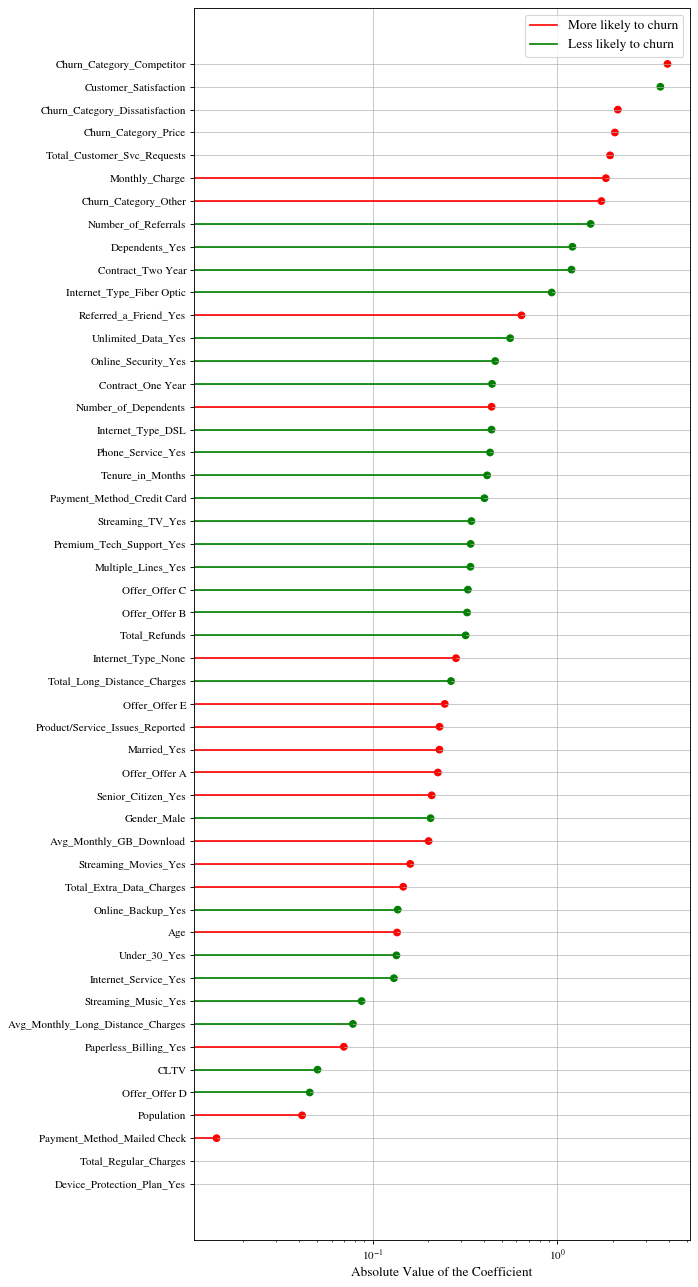

In [83]:
from matplotlib.lines import Line2D

## reshape coefficients into 1D array
coefficients = log_model_l1_Cprime.coef_.reshape([X_train.shape[1]])
tmp = [] ## empty array to fill with indicators

for coef in coefficients:
    if coef > 0:
        tmp.append(1) ## indicates positive coefficient
    elif coef < 0:
        tmp.append(-1) ## indicates negative coefficient
    else:
        tmp.append(0)

## Create dataframe of features and coefficients for plotting
colnames = X_train.columns
coef_df = pd.DataFrame({"feature": colnames,
                        "coef": np.abs(coefficients),
                        "influence": tmp}).sort_values("coef",ascending = True)


fig, ax = plt.subplots(figsize = (8,20))

## colour red for increased likelihood of cancellation, green otherwise
colors = np.where(coef_df['influence']==1, 'r', 'g') 

ax.scatter(coef_df["coef"],coef_df["feature"],c = colors) ## plot 

for i in range(X_train.shape[1]):
    ## add a stem to each point
    name = coef_df["feature"].to_numpy()[i]
    val = coef_df["coef"].to_numpy()[i]

    ## match stem colour to the colour of the point
    if coef_df["influence"].to_numpy()[i] == 1:
        ax.hlines(name,xmin = 0, xmax = val,colors = "r")
    else:
        ax.hlines(name,xmin = 0, xmax = val,colors = "g")

## set scale and insert legend
ax.set_xscale("log")
legend_elements = [Line2D([0], [0], color='r', label="More likely to churn"),
                   Line2D([0], [0], color='g', label='Less likely to churn')]

ax.legend(handles=legend_elements,fontsize = 12)
ax.grid(alpha =.75)

ax.set_xlabel("Absolute Value of the Coefficient")
plt.show()


## XGBoost feature importances

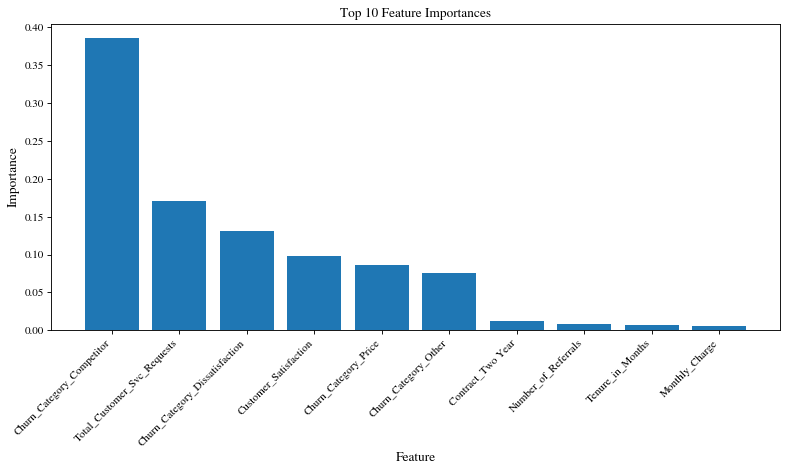

In [84]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

def plot_feature_importances(X, y, feature_names, num_features=10, **gb_params):
    # Train the GradientBoostingClassifier
    model = GradientBoostingClassifier(**gb_params)
    model.fit(X, y)

    # Get feature importances from the model
    importances = model.feature_importances_
    indices = importances.argsort()[-num_features:][::-1]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    # Create a bar plot for the top features
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features), top_importances, align='center')
    plt.xticks(range(num_features), top_features, rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top {} Feature Importances'.format(num_features))
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have the X_train, y_train, and feature_names ready
# Replace 'X_train' and 'y_train' with your actual training data
# Replace 'feature_names' with a list containing the names of your features
gb_params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
plot_feature_importances(X_train, y_train, feature_names, num_features=10, **gb_params)
